# Подготовка

In [19]:
import os
import random

import torch
import torchvision
from torchvision import datasets, models, transforms
import tqdm
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
print(f'torch.__version__ = {torch.__version__}')
print(f'torchvision.__version__ = {torchvision.__version__}')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device = {device} \n')

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(f'{gpu_info}')

torch.__version__ = 2.4.0+cu124
torchvision.__version__ = 0.19.0+cu124
device = cuda 

Wed Aug  7 01:35:36 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.78                 Driver Version: 550.78         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:05:00.0 Off |                    0 |
| N/A   39C    P0             26W /   70W |       3MiB /  15360MiB |      7%      Default |
|                                         |          

In [7]:
def seed_everything(seed):
    random.seed(seed) # фиксируем генератор случайных чисел
    os.environ['PYTHONHASHSEED'] = str(seed) # фиксируем заполнения хешей
    torch.manual_seed(seed) # фиксируем генератор случайных чисел pytorch
    torch.cuda.manual_seed(seed) # фиксируем генератор случайных чисел для GPU
    torch.backends.cudnn.deterministic = True # выбираем только детерминированные алгоритмы (для сверток)
    torch.backends.cudnn.benchmark = False # фиксируем алгоритм вычисления сверток

seed_everything(42)

In [22]:
# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

def show_batch(loader):
    dataiter = iter(loader)
    images, labels = next(dataiter)

    # Create a grid from the images and show them
    img_grid = torchvision.utils.make_grid(images)
    matplotlib_imshow(img_grid, one_channel=False)

# Основная часть

1. Скачать датасет ImageNette: https://github.com/fastai/imagenette (ImageNette это подвыборка из 10 классов датасета ImageNet).

In [20]:
dowload_needed = False

train_transforms =  transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

val_transforms =  transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])


train_set = datasets.Imagenette("./data", split="train", download=dowload_needed, transform=train_transforms)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

val_set = datasets.Imagenette("./data", split="val", download=dowload_needed, transform=val_transforms)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False)

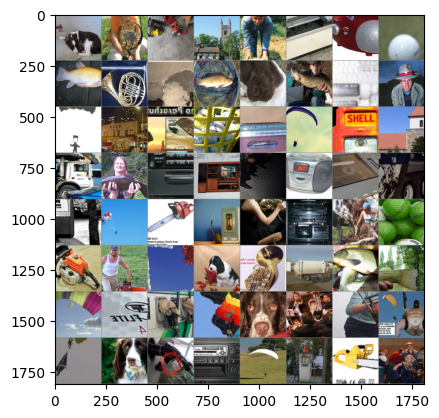

In [24]:
show_batch(train_loader)

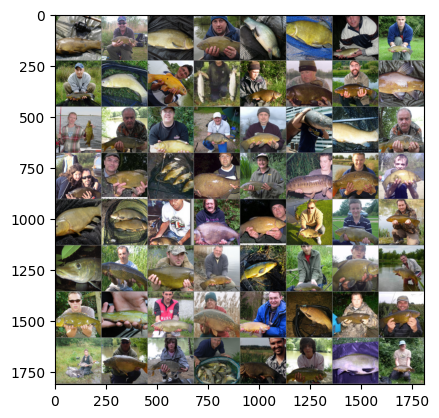

In [25]:
show_batch(val_loader)

2. Взять предобученную на обычном ImageNet модель (например, ResNet18) и заменить число классов на 10.

In [13]:
weights = models.ResNet18_Weights.DEFAULT
model = models.resnet18(weights=weights)


3. Дообучить модель на 10 классах ImageNette и замерить точность (это точность будет считаться базовой). Можно обучить как всю модель, так и только последний слой.
4. Сохранить последний слой на 10 классов (слой классификации).
5. Используя код с лекции дообучить модель классифицировать датасет CIFAR10.
6. Вернуть оригинальный последний слой модели и проверить качество на ImageNette и сравнить с базовой точностью.
7. Дообучить только последний слой (отключить градиент для всех слоев кроме последнего) на ImageNette и проверить удалось ли добиться исходного качества.
8. Сделать выводы.